In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

## Loading the data

In [ ]:
# loading in the dataset .csv training file
df = pd.read_csv("/content/correct_train.csv")
df

,change,paragraph1,paragraph2
0,1,How is this comment considered okay? It wouldn...,Also could be important as a lot of people thi...
1,0,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...
2,1,For those who have questions regarding any med...,There is literally no quicker way to guarantee...
3,0,There is literally no quicker way to guarantee...,"Granted, but he's a former football player. Th..."
4,1,"Granted, but he's a former football player. Th...",As usual they will try to elevate the black re...
...,...,...,...
21900,1,The Supreme Court is just waiting to throw awa...,"In general, be courteous to others. Debate/dis..."
21901,0,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...
21902,1,For those who have questions regarding any med...,We have a illegitimate Supreme Court and Biden...
21903,0,We have a illegitimate Supreme Court and Biden...,It had none since the day the overturning of R...


In [ ]:
# loading in the dataset .csv training file
df_val = pd.read_csv("/content/val.csv")
df_val

,change,paragraph1,paragraph2
0,1,They were so very lucky the capital Police did...,"In general, be courteous to others. Debate/dis..."
1,0,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...
2,0,In Sweden you can look up anyone’s crime recor...,"Yup, you can either contact our tax agency for..."
3,1,"Yup, you can either contact our tax agency for...",That cant be true for the most common simple p...
4,1,That cant be true for the most common simple p...,Sweden's kind of big on transparency. You can ...
...,...,...,...
4587,0,"If it was just ""one person's delusion"" then re...",Among normal population however and polls cond...
4588,0,Among normal population however and polls cond...,Let's not deceive ourselves - this was approve...
4589,1,Let's not deceive ourselves - this was approve...,“As long as it takes.” Just not what the Ukrai...
4590,1,"This is against the company, not Trump himself...","In general, be courteous to others. Debate/dis..."


In [ ]:
# checking the number of '0' and '1' values to see if data needs balancing
zeros_count = df[df['change'] == 0].shape[0]
ones_count = df[df['change'] == 1].shape[0]

print("Number of 0 values:", zeros_count)
print("Number of 1 values:", ones_count)

Number of 0 values: 9414
Number of 1 values: 12491


In [ ]:
unbalance_ratio = zeros_count/ones_count
unbalance_ratio

0.7536626370987111

In [ ]:
# checking the number of '0' and '1' values to see if data needs balancing
zeros_val_count = df_val[df_val['change'] == 0].shape[0]
ones_val_count = df_val[df_val['change'] == 1].shape[0]

print("Number of 0 values:", zeros_val_count)
print("Number of 1 values:", ones_val_count)

Number of 0 values: 1989
Number of 1 values: 2603


In [ ]:
unbalance_val_ratio = zeros_val_count/ones_val_count
unbalance_val_ratio

0.7641183250096043

## Euclidean distance function

In [ ]:
def euclidean_distance(value1, value2):
    # calculating Euclidean distance between two datapoints
    return np.linalg.norm(value1 - value2)

## *Flair* features extraction

In [ ]:
!pip install flair
!pip install flair.datasets

ERROR: Could not find a version that satisfies the requirement flair.datasets (from versions: none)
ERROR: No matching distribution found for flair.datasets


In [ ]:
from flair.data import Sentence
from flair.models import TextClassifier

In [ ]:
if torch.cuda.is_available():
    CUDA_DEVICE = 0
    print(f"Using GPU {CUDA_DEVICE}")
else:
    print("GPU not available, using CPU.")

Using GPU 0


In [ ]:
# loading the pre-trained sentiment classifier
sentiment_model = TextClassifier.load('en-sentiment')

def get_sentiment(text):
    sentence = Sentence(text)
    sentiment_model.predict(sentence)

    # extracting sentiment score, positive = 1, negative = - 1
    score = sentence.labels[0].score
    value = 1 if sentence.labels[0].value == 'POSITIVE' else -1
    return score * value

df['flair_sentiment1'] = df['paragraph1'].apply(get_sentiment)
df['flair_sentiment2'] = df['paragraph2'].apply(get_sentiment)

In [ ]:
# calculating sentiment difference
df['f_sentiment_difference'] = df.apply(lambda row: euclidean_distance(row['flair_sentiment1'],row['flair_sentiment2']), axis = 1)

In [ ]:
df

,change,paragraph1,paragraph2,flair_sentiment1,flair_sentiment2,f_sentiment_difference
0,1,How is this comment considered okay? It wouldn...,Also could be important as a lot of people thi...,-0.998378,0.851410,1.849789
1,0,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...,-0.999427,-0.950521,0.048906
2,1,For those who have questions regarding any med...,There is literally no quicker way to guarantee...,-0.950521,-0.999605,0.049083
3,0,There is literally no quicker way to guarantee...,"Granted, but he's a former football player. Th...",-0.999605,-0.970255,0.029349
4,1,"Granted, but he's a former football player. Th...",As usual they will try to elevate the black re...,-0.970255,-0.985732,0.015477
...,...,...,...,...,...,...
21900,1,The Supreme Court is just waiting to throw awa...,"In general, be courteous to others. Debate/dis...",-0.996878,-0.999427,0.002549
21901,0,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...,-0.999427,-0.950521,0.048906
21902,1,For those who have questions regarding any med...,We have a illegitimate Supreme Court and Biden...,-0.950521,-0.875771,0.074750
21903,0,We have a illegitimate Supreme Court and Biden...,It had none since the day the overturning of R...,-0.875771,-0.997884,0.122113


In [ ]:
# getting flair sentiment score for validation df
df_val['flair_sentiment1'] = df_val['paragraph1'].apply(get_sentiment)
df_val['flair_sentiment2'] = df_val['paragraph2'].apply(get_sentiment)

# calculating sentiment difference for validation df
df_val['f_sentiment_difference'] = df_val.apply(lambda row: euclidean_distance(row['flair_sentiment1'],row['flair_sentiment2']), axis = 1)

In [ ]:
df_val

,change,paragraph1,paragraph2,flair_sentiment1,flair_sentiment2,f_sentiment_difference
0,1,They were so very lucky the capital Police did...,"In general, be courteous to others. Debate/dis...",-0.998615,-0.999427,0.000812
1,0,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...,-0.999427,-0.950521,0.048906
2,0,In Sweden you can look up anyone’s crime recor...,"Yup, you can either contact our tax agency for...",-0.998666,-0.999869,0.001203
3,1,"Yup, you can either contact our tax agency for...",That cant be true for the most common simple p...,-0.999869,-0.854716,0.145153
4,1,That cant be true for the most common simple p...,Sweden's kind of big on transparency. You can ...,-0.854716,0.999500,1.854216
...,...,...,...,...,...,...
4587,0,"If it was just ""one person's delusion"" then re...",Among normal population however and polls cond...,-0.999176,0.997719,1.996894
4588,0,Among normal population however and polls cond...,Let's not deceive ourselves - this was approve...,0.997719,0.990144,0.007575
4589,1,Let's not deceive ourselves - this was approve...,“As long as it takes.” Just not what the Ukrai...,0.990144,-0.999749,1.989892
4590,1,"This is against the company, not Trump himself...","In general, be courteous to others. Debate/dis...",-0.999949,-0.999427,0.000522


## First basic Logistic Regression model

In [ ]:
# Logistic Regression model based on one feature

# splitting data into training and testing sets
X = df[['f_sentiment_difference']]
y = df['change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# training a logistic regression model
euclidean_model = LogisticRegression()
euclidean_model.fit(X_train, y_train)

# making predictions
predictions = euclidean_model.predict(X_test)

# evaluation
accuracy = f1_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.729039744705541


In [ ]:
# checking the coefficients of the logistic regression model
coefficients = euclidean_model.coef_

# mapping the feature names to their coefficients
feature_coefficients = dict(zip(X, coefficients))

print("Feature coefficients:")
for feature, coefficient in feature_coefficients.items():
    print(f"{feature}: {coefficient}")

Feature coefficients:
f_sentiment_difference: [0.28194351]


Accuracy of the model above is 0.72 even though the coefficient for the only feature the model is trained on has a low value (0.28), which suggests that the feature does not influence the model predictive behavior a lot. The high accuracy score is probably cause by the fact that our data is unbalanced. We have:
*  number of 0 values: 9414
*  number of 1 values: 12491

What Logistic Regression model might be learning at this point is to not use the feature information at all, instead it can always predict the label = 1 and still achieve quite high accuracy.

Of course we need to balance the data. As our models will be trained on features, we do it after we extract features from the *Textstat* packagge

## *Textstat* Features Extraction

In [ ]:
!pip install textstat
!pip install textblob

In [ ]:
import textstat
from textblob import TextBlob

Below, we define several functions for different features extraction:

In [ ]:
import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

# sentiment intensity score
def get_sentiment_score(text):
    if text is not None:
        return sid.polarity_scores(text)['compound']
    else:
        return 0  # You can choose how to handle missing values here

# difficult/complex words count
def complex_words(text):
    return textstat.difficult_words(text)

# lexicon count = unique words divided by all of the words
def lexicon_count(text):
  total_words = textstat.lexicon_count(text, removepunct = True)
  tokens = text.split()
  unique_words = set(tokens)
  unique_word_count = len(unique_words)
  if total_words == 0:  # handling division by zero
        return 0
  else:
        return unique_word_count / total_words

# Dale-Chall Readability Score: assesses readability based on a list of familiar words
def dale_chall_readability(text):
  return textstat.dale_chall_readability_score(text)

# Flesch Reading Ease: measures text readability on a scale from 0 to 100
def flesch_readability(text):
  return textstat.flesch_reading_ease(text)

# measuring the subjectivity of a text
def subjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# percentage of complex/difficult words in the text
def percent_complexity(text):
  total_words = textstat.lexicon_count(text, removepunct = True)
  complex_words = textstat.difficult_words(text)
  return (complex_words / total_words) * 100 if total_words != 0 else 0

# count of monosyllabic words
def monosyllabic_words(text):
    words = text.split()
    monosyllabic_words = [word for word in words if textstat.syllable_count(word) == 1]
    return len(monosyllabic_words)

# words count
def word_count(text):
    return textstat.lexicon_count(text, removepunct=True)

# sentences count
def sentence_count(text):
    return textstat.sentence_count(text)

# average word length
def average_word_length(text):
    words = text.split()
    word_lengths = [len(word) for word in words if len(word) > 0]  # excluding empty strings
    if len(word_lengths) == 0:  # handling division by zero
        return 0
    else:
        return sum(word_lengths) / len(word_lengths)

# average sentence length
def average_sentence_length(text):
    sentences = textstat.sentence_count(text)
    words = textstat.lexicon_count(text, removepunct = True)
    if sentences == 0:  # handling division by zero
        return 0
    else:
        return words / sentences


# adding features to our dataframe
def create_features_df(df):

  df['sentiment_score1'] = df['paragraph1'].apply(get_sentiment_score)
  df['sentiment_score2'] = df['paragraph2'].apply(get_sentiment_score)

  df['dc_readability1'] = df['paragraph1'].apply(dale_chall_readability)
  df['dc_readability2'] = df['paragraph2'].apply(dale_chall_readability)

  df['fle_readability1'] = df['paragraph1'].apply(flesch_readability)
  df['fle_readability2'] = df['paragraph2'].apply(flesch_readability)

  df['subjectivity1'] = df['paragraph1'].apply(subjectivity)
  df['subjectivity2'] = df['paragraph2'].apply(subjectivity)

  df['complex_words_percentage1'] = df['paragraph1'].apply(percent_complexity)
  df['complex_words_percentage2'] = df['paragraph2'].apply(percent_complexity)

  df['monosyllabic1'] = df['paragraph1'].apply(monosyllabic_words)
  df['monosyllabic2'] = df['paragraph2'].apply(monosyllabic_words)

  df['complex_words1'] = df['paragraph1'].apply(complex_words)
  df['complex_words2'] = df['paragraph2'].apply(complex_words)

  df['lexicon1'] = df['paragraph1'].apply(lexicon_count)
  df['lexicon2'] = df['paragraph2'].apply(lexicon_count)

  df['word_count1'] = df['paragraph1'].apply(word_count)
  df['word_count2'] = df['paragraph2'].apply(word_count)

  df['sentence_count1'] = df['paragraph1'].apply(sentence_count)
  df['sentence_count2'] = df['paragraph2'].apply(sentence_count)

  df['avg_word_length1'] = df['paragraph1'].apply(average_word_length)
  df['avg_word_length2'] = df['paragraph2'].apply(average_word_length)

  df['avg_sent_length1'] = df['paragraph1'].apply(average_sentence_length)
  df['avg_sent_length2'] = df['paragraph2'].apply(average_sentence_length)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
create_features_df(df)
df

,change,paragraph1,paragraph2,flair_sentiment1,flair_sentiment2,f_sentiment_difference,sentiment_score1,sentiment_score2,dc_readability1,dc_readability2,...,lexicon1,lexicon2,word_count1,word_count2,sentence_count1,sentence_count2,avg_word_length1,avg_word_length2,avg_sent_length1,avg_sent_length2
0,1,How is this comment considered okay? It wouldn...,Also could be important as a lot of people thi...,-0.998378,0.851410,1.849789,-0.3921,0.2263,8.86,8.71,...,0.690909,0.931034,220,29,11,2,5.118182,5.068966,20.000000,14.500000
1,0,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...,-0.999427,-0.950521,0.048906,-0.9520,0.6249,11.63,11.06,...,0.926829,0.931034,41,29,3,1,5.585366,5.103448,13.666667,29.000000
2,1,For those who have questions regarding any med...,There is literally no quicker way to guarantee...,-0.950521,-0.999605,0.049083,0.6249,0.0839,11.06,8.57,...,0.931034,0.920000,29,50,1,3,5.103448,4.660000,29.000000,16.666667
3,0,There is literally no quicker way to guarantee...,"Granted, but he's a former football player. Th...",-0.999605,-0.970255,0.029349,0.0839,0.1280,8.57,7.38,...,0.920000,0.896552,50,29,3,3,4.660000,4.620690,16.666667,9.666667
4,1,"Granted, but he's a former football player. Th...",As usual they will try to elevate the black re...,-0.970255,-0.985732,0.015477,0.1280,-0.3407,7.38,8.55,...,0.896552,0.804348,29,46,3,2,4.620690,4.282609,9.666667,23.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21900,1,The Supreme Court is just waiting to throw awa...,"In general, be courteous to others. Debate/dis...",-0.996878,-0.999427,0.002549,0.8074,-0.9520,8.48,11.63,...,0.944444,0.926829,36,41,2,3,4.416667,5.585366,18.000000,13.666667
21901,0,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...,-0.999427,-0.950521,0.048906,-0.9520,0.6249,11.63,11.06,...,0.926829,0.931034,41,29,3,1,5.585366,5.103448,13.666667,29.000000
21902,1,For those who have questions regarding any med...,We have a illegitimate Supreme Court and Biden...,-0.950521,-0.875771,0.074750,0.6249,0.5574,11.06,7.92,...,0.931034,1.000000,29,21,1,2,5.103448,4.666667,29.000000,10.500000
21903,0,We have a illegitimate Supreme Court and Biden...,It had none since the day the overturning of R...,-0.875771,-0.997884,0.122113,0.5574,0.4404,7.92,8.17,...,1.000000,0.827586,21,29,2,2,4.666667,4.034483,10.500000,14.500000


In [ ]:
create_features_df(df_val)
df_val

,change,paragraph1,paragraph2,flair_sentiment1,flair_sentiment2,f_sentiment_difference,sentiment_score1,sentiment_score2,dc_readability1,dc_readability2,...,lexicon1,lexicon2,word_count1,word_count2,sentence_count1,sentence_count2,avg_word_length1,avg_word_length2,avg_sent_length1,avg_sent_length2
0,1,They were so very lucky the capital Police did...,"In general, be courteous to others. Debate/dis...",-0.998615,-0.999427,0.000812,-0.5018,-0.9520,7.45,11.63,...,0.705128,0.926829,156,41,10,3,4.506410,5.585366,15.600000,13.666667
1,0,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...,-0.999427,-0.950521,0.048906,-0.9520,0.6249,11.63,11.06,...,0.926829,0.931034,41,29,3,1,5.585366,5.103448,13.666667,29.000000
2,0,In Sweden you can look up anyone’s crime recor...,"Yup, you can either contact our tax agency for...",-0.998666,-0.999869,0.001203,-0.3602,0.4404,10.44,9.96,...,0.867925,0.925000,53,40,1,1,4.452830,4.400000,53.000000,40.000000
3,1,"Yup, you can either contact our tax agency for...",That cant be true for the most common simple p...,-0.999869,-0.854716,0.145153,0.4404,-0.6632,9.96,7.73,...,0.925000,0.911765,40,34,1,2,4.400000,4.264706,40.000000,17.000000
4,1,That cant be true for the most common simple p...,Sweden's kind of big on transparency. You can ...,-0.854716,0.999500,1.854216,-0.6632,0.5423,7.73,8.00,...,0.911765,0.892857,34,56,2,4,4.264706,4.553571,17.000000,14.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4587,0,"If it was just ""one person's delusion"" then re...",Among normal population however and polls cond...,-0.999176,0.997719,1.996894,-0.7003,0.9480,9.20,10.71,...,0.891304,0.863636,46,66,3,3,5.434783,5.227273,15.333333,22.000000
4588,0,Among normal population however and polls cond...,Let's not deceive ourselves - this was approve...,0.997719,0.990144,0.007575,0.9480,0.2333,10.71,8.56,...,0.863636,0.909091,66,55,3,3,5.227273,4.821429,22.000000,18.333333
4589,1,Let's not deceive ourselves - this was approve...,“As long as it takes.” Just not what the Ukrai...,0.990144,-0.999749,1.989892,0.2333,0.0000,8.56,6.60,...,0.909091,0.947368,55,19,3,2,4.821429,4.368421,18.333333,9.500000
4590,1,"This is against the company, not Trump himself...","In general, be courteous to others. Debate/dis...",-0.999949,-0.999427,0.000522,-0.3612,-0.9520,8.40,11.63,...,0.747899,0.926829,119,41,5,3,4.924370,5.585366,23.800000,13.666667


In [ ]:
# calculating Euclidean distance for the extracted features and adding it as a additional column in df
def create_difference_columns(df):
  df['sentiment_difference'] = df.apply(lambda row: euclidean_distance(row['sentiment_score1'], row['sentiment_score2']), axis=1)
  df['complexwords_difference'] = df.apply(lambda row: euclidean_distance(row['complex_words1'], row['complex_words2']), axis=1)
  df['lexiconcount_difference'] = df.apply(lambda row: euclidean_distance(row['lexicon1'], row['lexicon2']), axis=1)
  df['dc_readability_difference'] = df.apply(lambda row: euclidean_distance(row['dc_readability1'], row['dc_readability2']), axis=1)
  df['fle_readability_difference'] = df.apply(lambda row: euclidean_distance(row['fle_readability1'], row['fle_readability2']), axis=1)
  df['subjectivity_difference'] = df.apply(lambda row: euclidean_distance(row['subjectivity1'], row['subjectivity2']), axis=1)
  df['complex_perc_difference'] = df.apply(lambda row: euclidean_distance(row['complex_words_percentage1'], row['complex_words_percentage2']), axis=1)
  df['monosyllabic_difference'] = df.apply(lambda row: euclidean_distance(row['monosyllabic1'], row['monosyllabic2']), axis=1)
  df['word_count_difference'] = df.apply(lambda row: euclidean_distance(row['word_count1'], row['word_count2']), axis=1)
  df['sent_count_difference'] = df.apply(lambda row: euclidean_distance(row['sentence_count1'], row['sentence_count2']), axis=1)
  df['avg_word_length_difference'] = df.apply(lambda row: euclidean_distance(row['avg_word_length1'], row['avg_word_length2']), axis=1)
  df['avg_sent_length_difference'] = df.apply(lambda row: euclidean_distance(row['avg_sent_length1'], row['avg_sent_length2']), axis=1)

In [ ]:
create_difference_columns(df)
df

,change,paragraph1,paragraph2,flair_sentiment1,flair_sentiment2,f_sentiment_difference,sentiment_score1,sentiment_score2,dc_readability1,dc_readability2,...,lexiconcount_difference,dc_readability_difference,fle_readability_difference,subjectivity_difference,complex_perc_difference,monosyllabic_difference,word_count_difference,sent_count_difference,avg_word_length_difference,avg_sent_length_difference
0,1,How is this comment considered okay? It wouldn...,Also could be important as a lot of people thi...,-0.998378,0.851410,1.849789,-0.3921,0.2263,8.86,8.71,...,0.240125,0.15,11.34,0.211264,6.865204,134.0,191.0,9.0,0.049216,5.500000
1,0,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...,-0.999427,-0.950521,0.048906,-0.9520,0.6249,11.63,11.06,...,0.004205,0.57,1.39,0.615000,1.345669,8.0,12.0,2.0,0.481918,15.333333
2,1,For those who have questions regarding any med...,There is literally no quicker way to guarantee...,-0.950521,-0.999605,0.049083,0.6249,0.0839,11.06,8.57,...,0.011034,2.49,20.94,0.520833,21.931034,20.0,21.0,2.0,0.443448,12.333333
3,0,There is literally no quicker way to guarantee...,"Granted, but he's a former football player. Th...",-0.999605,-0.970255,0.029349,0.0839,0.1280,8.57,7.38,...,0.023448,1.19,24.03,0.220833,1.241379,16.0,21.0,0.0,0.039310,7.000000
4,1,"Granted, but he's a former football player. Th...",As usual they will try to elevate the black re...,-0.970255,-0.985732,0.015477,0.1280,-0.3407,7.38,8.55,...,0.092204,1.17,13.50,0.147222,2.023988,16.0,17.0,1.0,0.338081,13.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21900,1,The Supreme Court is just waiting to throw awa...,"In general, be courteous to others. Debate/dis...",-0.996878,-0.999427,0.002549,0.8074,-0.9520,8.48,11.63,...,0.017615,3.15,37.94,0.381667,25.474255,6.0,5.0,1.0,1.168699,4.333333
21901,0,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...,-0.999427,-0.950521,0.048906,-0.9520,0.6249,11.63,11.06,...,0.004205,0.57,1.39,0.615000,1.345669,8.0,12.0,2.0,0.481918,15.333333
21902,1,For those who have questions regarding any med...,We have a illegitimate Supreme Court and Biden...,-0.950521,-0.875771,0.074750,0.6249,0.5574,11.06,7.92,...,0.068966,3.14,27.24,0.000000,23.645320,0.0,8.0,1.0,0.436782,18.500000
21903,0,We have a illegitimate Supreme Court and Biden...,It had none since the day the overturning of R...,-0.875771,-0.997884,0.122113,0.5574,0.4404,7.92,8.17,...,0.172414,0.25,12.86,0.750000,3.940887,9.0,8.0,0.0,0.632184,4.000000


In [ ]:
create_difference_columns(df_val)
df_val

,change,paragraph1,paragraph2,flair_sentiment1,flair_sentiment2,f_sentiment_difference,sentiment_score1,sentiment_score2,dc_readability1,dc_readability2,...,lexiconcount_difference,dc_readability_difference,fle_readability_difference,subjectivity_difference,complex_perc_difference,monosyllabic_difference,word_count_difference,sent_count_difference,avg_word_length_difference,avg_sent_length_difference
0,1,They were so very lucky the capital Police did...,"In general, be courteous to others. Debate/dis...",-0.998615,-0.999427,0.000812,-0.5018,-0.9520,7.45,11.63,...,0.221701,4.18,31.91,0.140272,21.200750,85.0,115.0,7.0,1.078956,1.933333
1,0,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...,-0.999427,-0.950521,0.048906,-0.9520,0.6249,11.63,11.06,...,0.004205,0.57,1.39,0.615000,1.345669,8.0,12.0,2.0,0.481918,15.333333
2,0,In Sweden you can look up anyone’s crime recor...,"Yup, you can either contact our tax agency for...",-0.998666,-0.999869,0.001203,-0.3602,0.4404,10.44,9.96,...,0.057075,0.48,4.74,0.158333,8.018868,10.0,13.0,0.0,0.052830,13.000000
3,1,"Yup, you can either contact our tax agency for...",That cant be true for the most common simple p...,-0.999869,-0.854716,0.145153,0.4404,-0.6632,9.96,7.73,...,0.013235,2.23,31.80,0.348980,13.235294,2.0,6.0,1.0,0.135294,23.000000
4,1,That cant be true for the most common simple p...,Sweden's kind of big on transparency. You can ...,-0.854716,0.999500,1.854216,-0.6632,0.5423,7.73,8.00,...,0.018908,0.27,3.05,0.071202,2.521008,16.0,22.0,2.0,0.288866,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4587,0,"If it was just ""one person's delusion"" then re...",Among normal population however and polls cond...,-0.999176,0.997719,1.996894,-0.7003,0.9480,9.20,10.71,...,0.027668,1.51,1.66,0.311548,0.988142,16.0,20.0,0.0,0.207510,6.666667
4588,0,Among normal population however and polls cond...,Let's not deceive ourselves - this was approve...,0.997719,0.990144,0.007575,0.9480,0.2333,10.71,8.56,...,0.045455,2.15,3.75,0.223423,3.636364,9.0,11.0,0.0,0.405844,3.666667
4589,1,Let's not deceive ourselves - this was approve...,“As long as it takes.” Just not what the Ukrai...,0.990144,-0.999749,1.989892,0.2333,0.0000,8.56,6.60,...,0.038278,1.96,42.77,0.038125,18.373206,16.0,36.0,1.0,0.453008,8.833333
4590,1,"This is against the company, not Trump himself...","In general, be courteous to others. Debate/dis...",-0.999949,-0.999427,0.000522,-0.3612,-0.9520,8.40,11.63,...,0.178930,3.23,15.13,0.078636,21.459315,61.0,78.0,2.0,0.660996,10.133333


In [ ]:
df.shape

(21905, 42)

In [ ]:
df_val.shape

(4592, 42)

In [ ]:
''' Defining a function that will return a dataframe
    which consists only from difference scores of features
    from two adjacent paragraphs '''

def get_difference_columns(df):
    # creating an empty dataframe to store the columns
    df_diff = pd.DataFrame()

    # iterating through the column names of current dataframe
    for column in df.columns:

        # checking if the column name ends with '_difference'
        if column.endswith('_difference'):
            # adding column to new dataframe
            df_diff[column] = df[column]

    return df_diff

In [ ]:
df_diff = get_difference_columns(df)

# adding change_label column to data
df_diff.insert(0, 'change', df['change'])

df_diff

,change,f_sentiment_difference,sentiment_difference,complexwords_difference,lexiconcount_difference,dc_readability_difference,fle_readability_difference,subjectivity_difference,complex_perc_difference,monosyllabic_difference,word_count_difference,sent_count_difference,avg_word_length_difference,avg_sent_length_difference
0,1,1.849789,0.6184,31.0,0.240125,0.15,11.34,0.211264,6.865204,134.0,191.0,9.0,0.049216,5.500000
1,0,0.048906,1.5769,4.0,0.004205,0.57,1.39,0.615000,1.345669,8.0,12.0,2.0,0.481918,15.333333
2,1,0.049083,0.5410,3.0,0.011034,2.49,20.94,0.520833,21.931034,20.0,21.0,2.0,0.443448,12.333333
3,0,0.029349,0.0441,3.0,0.023448,1.19,24.03,0.220833,1.241379,16.0,21.0,0.0,0.039310,7.000000
4,1,0.015477,0.4687,2.0,0.092204,1.17,13.50,0.147222,2.023988,16.0,17.0,1.0,0.338081,13.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21900,1,0.002549,1.7594,11.0,0.017615,3.15,37.94,0.381667,25.474255,6.0,5.0,1.0,1.168699,4.333333
21901,0,0.048906,1.5769,4.0,0.004205,0.57,1.39,0.615000,1.345669,8.0,12.0,2.0,0.481918,15.333333
21902,1,0.074750,0.0675,8.0,0.068966,3.14,27.24,0.000000,23.645320,0.0,8.0,1.0,0.436782,18.500000
21903,0,0.122113,0.1170,0.0,0.172414,0.25,12.86,0.750000,3.940887,9.0,8.0,0.0,0.632184,4.000000


In [ ]:
df_diff.shape

(21905, 14)

In [ ]:
df_val_diff = get_difference_columns(df_val)

# adding change_label column to data
df_val_diff.insert(0, 'change', df_val['change'])

df_val_diff

,change,f_sentiment_difference,sentiment_difference,complexwords_difference,lexiconcount_difference,dc_readability_difference,fle_readability_difference,subjectivity_difference,complex_perc_difference,monosyllabic_difference,word_count_difference,sent_count_difference,avg_word_length_difference,avg_sent_length_difference
0,1,0.000812,0.4502,9.0,0.221701,4.18,31.91,0.140272,21.200750,85.0,115.0,7.0,1.078956,1.933333
1,0,0.048906,1.5769,4.0,0.004205,0.57,1.39,0.615000,1.345669,8.0,12.0,2.0,0.481918,15.333333
2,0,0.001203,0.8006,1.0,0.057075,0.48,4.74,0.158333,8.018868,10.0,13.0,0.0,0.052830,13.000000
3,1,0.145153,1.1036,6.0,0.013235,2.23,31.80,0.348980,13.235294,2.0,6.0,1.0,0.135294,23.000000
4,1,1.854216,1.2055,4.0,0.018908,0.27,3.05,0.071202,2.521008,16.0,22.0,2.0,0.288866,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4587,0,1.996894,1.6483,5.0,0.027668,1.51,1.66,0.311548,0.988142,16.0,20.0,0.0,0.207510,6.666667
4588,0,0.007575,0.7147,5.0,0.045455,2.15,3.75,0.223423,3.636364,9.0,11.0,0.0,0.405844,3.666667
4589,1,1.989892,0.2333,12.0,0.038278,1.96,42.77,0.038125,18.373206,16.0,36.0,1.0,0.453008,8.833333
4590,1,0.000522,0.5908,3.0,0.178930,3.23,15.13,0.078636,21.459315,61.0,78.0,2.0,0.660996,10.133333


In [ ]:
df_val_diff.shape

(4592, 14)

## Balancing data and choosing the best model
Choosing from:
*  Logistic Regression
*  SVM
*  Random Forest

In [ ]:
pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# splitting data into training and testing sets
X = df_diff.iloc[:, 1:]
y = df_diff['change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# defining resampling techniques to see which performs the best
resamplers = {'RandomOverSampler': RandomOverSampler(random_state = 42), 'SMOTE': SMOTE(random_state = 42), 'ADASYN': ADASYN(random_state = 42)}

# function to train and evaluate model
def train_evaluate_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

# Logistic Regression and SVM models to evaluate
logistic_regression = LogisticRegression(max_iter = 1000, random_state = 42)
svm = SVC(random_state = 42)
random_forest = RandomForestClassifier(n_estimators=100, random_state = 42)

# evaluating each resampling technique
for name, sampler in resamplers.items():
    print(f"\nUsing {name}:")

    # resampling the training data
    X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)

    # training and evaluating Logistic Regression model
    lr_accuracy = train_evaluate_model(X_resampled, y_resampled, X_test_scaled, y_test, logistic_regression)
    print(f"Logistic Regression f1 score: {lr_accuracy}")

    # training and evaluating SVM
    svm_accuracy = train_evaluate_model(X_resampled, y_resampled, X_test_scaled, y_test, svm)
    print(f"SVM f1 score: {svm_accuracy}")

    # training and evaluating Random Forest model
    rf_accuracy = train_evaluate_model(X_resampled, y_resampled, X_test_scaled, y_test, random_forest)
    print(f"Random Forest f1 score: {lr_accuracy}")



Using RandomOverSampler:
Logistic Regression f1 score: 0.6656879194630873
SVM f1 score: 0.7024655244463017
Random Forest f1 score: 0.6656879194630873

Using SMOTE:
Logistic Regression f1 score: 0.665965944923271
SVM f1 score: 0.6941870261162595
Random Forest f1 score: 0.665965944923271

Using ADASYN:
Logistic Regression f1 score: 0.6676415291414247
SVM f1 score: 0.6944971537001897
Random Forest f1 score: 0.6676415291414247


In [ ]:
sampler = ADASYN(random_state = 42)
# sampler = RandomOverSampler(random_state = 42)

# function to train and evaluate model
def train_evaluate_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

svm = SVC(random_state = 42)

X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)
svm.fit(X_resampled, y_resampled)
y_pred = svm.predict(X_test_scaled)

svm_accuracy = f1_score(y_test, y_pred)
print('SVM f1 score:', svm_accuracy)

SVM f1 score: 0.6944971537001897


In [ ]:
X_val = df_val_diff.iloc[:, 1:]
y_val = df_val_diff['change']

X_val_scaled = scaler.transform(X_val)

# making predictions on the validation set
y_val_pred = svm.predict(X_val_scaled)

# calculating evaluation metrics
val_f1 = f1_score(y_val, y_val_pred)

print(f"SVM validation f1 score: {val_f1}")

SVM validation f1 score: 0.7198873919163483


In [ ]:
# Feature selection using SelectKBest
k_values = [1, 3, 5, 6, 7, 10, 11, 12, 13]
accuracies = []

for k in k_values:
  selector = SelectKBest(score_func = f_classif, k = k)
  X_train_selected = selector.fit_transform(X_resampled, y_resampled)
  X_test_selected = selector.transform(X_test_scaled)

  # Get selected feature names
  selected_feature_names = X.columns[selector.get_support()].tolist()

  # Train SVM model on selected features
  svm_model = SVC()
  svm_model.fit(X_train_selected, y_resampled)

  # Make predictions on test data
  y_pred = svm_model.predict(X_test_selected)

  # Evaluate model performance
  accuracy = f1_score(y_test, y_pred)
  accuracies.append((k, accuracy, selected_feature_names))

print("Accuracy score for given k values:")
for k, accuracy, features in accuracies:
  print(f"k = {k}, accuracy = {accuracy}, \nselected features = {features}")

Accuracy score for given k values:
k = 1, accuracy = 0.6955183689170994, 
selected features = ['complex_perc_difference']
k = 3, accuracy = 0.7055630936227951, 
selected features = ['sentiment_difference', 'lexiconcount_difference', 'complex_perc_difference']
k = 5, accuracy = 0.714859437751004, 
selected features = ['sentiment_difference', 'lexiconcount_difference', 'complex_perc_difference', 'monosyllabic_difference', 'word_count_difference']
k = 6, accuracy = 0.7115570133127532, 
selected features = ['sentiment_difference', 'lexiconcount_difference', 'fle_readability_difference', 'complex_perc_difference', 'monosyllabic_difference', 'word_count_difference']
k = 7, accuracy = 0.7090558766859346, 
selected features = ['sentiment_difference', 'lexiconcount_difference', 'dc_readability_difference', 'fle_readability_difference', 'complex_perc_difference', 'monosyllabic_difference', 'word_count_difference']
k = 10, accuracy = 0.7079823505816286, 
selected features = ['f_sentiment_differen

In [ ]:
# creating new dataframe for k = 5 best features
df_best = df_diff[['change', 'sentiment_difference', 'lexiconcount_difference', 'complex_perc_difference', 'monosyllabic_difference', 'word_count_difference']]

In [ ]:
df_best

,change,sentiment_difference,lexiconcount_difference,complex_perc_difference,monosyllabic_difference,word_count_difference
0,1,0.6184,0.240125,6.865204,134.0,191.0
1,0,1.5769,0.004205,1.345669,8.0,12.0
2,1,0.5410,0.011034,21.931034,20.0,21.0
3,0,0.0441,0.023448,1.241379,16.0,21.0
4,1,0.4687,0.092204,2.023988,16.0,17.0
...,...,...,...,...,...,...
21900,1,1.7594,0.017615,25.474255,6.0,5.0
21901,0,1.5769,0.004205,1.345669,8.0,12.0
21902,1,0.0675,0.068966,23.645320,0.0,8.0
21903,0,0.1170,0.172414,3.940887,9.0,8.0


In [ ]:
# splitting data into training and testing sets
X = df_best.iloc[:, 1:]
y = df_best['change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_kbest = SVC(random_state = 42)
sampler = ADASYN(random_state = 42)

# resampling the training data
X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)

# training and evaluating SVM model
kbest_accuracy = train_evaluate_model(X_resampled, y_resampled, X_test_scaled, y_test, svm_kbest)
print('SVM accuracy for k best features:', kbest_accuracy, '\nSVM accuracy for all features:', svm_accuracy)

SVM accuracy for k best features: 0.73300528521961 
SVM accuracy for all features: 0.6944971537001897


In [ ]:
# creating new validation dataframe for k = 5 best features
df_val_best = df_val_diff[['change', 'sentiment_difference', 'lexiconcount_difference', 'complex_perc_difference', 'monosyllabic_difference', 'word_count_difference']]

In [ ]:
df_val_best

,change,sentiment_difference,lexiconcount_difference,complex_perc_difference,monosyllabic_difference,word_count_difference
0,1,0.4502,0.221701,21.200750,85.0,115.0
1,0,1.5769,0.004205,1.345669,8.0,12.0
2,0,0.8006,0.057075,8.018868,10.0,13.0
3,1,1.1036,0.013235,13.235294,2.0,6.0
4,1,1.2055,0.018908,2.521008,16.0,22.0
...,...,...,...,...,...,...
4587,0,1.6483,0.027668,0.988142,16.0,20.0
4588,0,0.7147,0.045455,3.636364,9.0,11.0
4589,1,0.2333,0.038278,18.373206,16.0,36.0
4590,1,0.5908,0.178930,21.459315,61.0,78.0


In [ ]:
X_val = df_val_best.iloc[:, 1:]
y_val = df_val_best['change']

X_val_scaled = scaler.transform(X_val)

svm_kbest.fit(X_resampled, y_resampled)

# making predictions on the validation set
y_val_pred = svm_kbest.predict(X_val_scaled)

# calculating evaluation metrics
kbest_val_f1 = f1_score(y_val, y_val_pred)

print('SVM validation f1 score for k best features:', kbest_val_f1, '\nSVM validation f1 score for all features:', val_f1 )

SVM validation f1 score for k best features: 0.7343389529724933 
SVM validation f1 score for all features: 0.7198873919163483


## FINE-TUNING SVM

In [ ]:
from sklearn.model_selection import GridSearchCV

# splitting data into training and testing sets
X = df_best.iloc[:, 1:]
y = df_best['change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# initializing SVM and resampler
svm_hyper = SVC(random_state = 42)
sampler = ADASYN(random_state = 42)

# resampling the training data
X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)

# hyperparameter tuning for the best model performance
param_grid = {'C': [0.1, 0.5, 1], 'kernel': ['linear', 'rbf']}

# using GridSearchCV with verbose parameter to print the current hyperparameters being checked
grid_search = GridSearchCV(svm_hyper, param_grid, cv = 5, scoring = 'f1', n_jobs = -1, verbose = 3) # n_jobs for parallel computation
grid_search.fit(X_resampled, y_resampled)

# the best model
best_svm_model = grid_search.best_estimator_

# training and evaluating the model
best_svm_model.fit(X_resampled, y_resampled)
y_pred = best_svm_model.predict(X_test_scaled)
accuracy = f1_score(y_test, y_pred)

# making predictions on the validation set
y_val_pred = best_svm_model.predict(X_val_scaled)

# calculating evaluation metrics
best_val_f1 = f1_score(y_val, y_val_pred)

print('SVM f1 score for the best model hyperparameters:', accuracy, '\nSVM f1 score for the best model hyperparameters for validation dataset:', best_val_f1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


SVM f1 score for the best model hyperparameters: 0.7341909766262005 
SVM f1 score for the best model hyperparameters for validation dataset: 0.7344632768361581


In [ ]:
# Getting the best parameters from the grid search
best_params = grid_search.best_params_
best_C = best_params['C']
best_kernel = best_params['kernel']

print("Best C:", best_C)
print("Best kernel:", best_kernel)

Best C: 0.5
Best kernel: rbf


In [ ]:
# SVM with the best parameters
best_svm_model = SVC(C = 0.5, kernel = 'rbf')

# Training the final SVM model on the selected features
best_svm_model.fit(X_resampled, y_resampled)

# Making predictions on the test data
y_val_pred = best_svm_model.predict(X_val_scaled)

# Evaluating model performance using F1-score
final_accuracy = f1_score(y_val, y_val_pred)
print('SVM accuracy after fine-tuning for k best features:', final_accuracy, '\nSVM accuracy for k best features:', kbest_val_f1, '\nSVM accuracy for all features:', val_f1)

SVM accuracy after fine-tuning for k best features: 0.7344632768361581 
SVM accuracy for k best features: 0.7343389529724933 
SVM accuracy for all features: 0.7198873919163483


## Logistic Regression Model

In [ ]:
# splitting data into training and testing sets
X = df_diff.iloc[:, 1:]
y = df_diff['change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sampler = ADASYN(random_state = 42)

X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)

# testing different solvers than just the default one
solvers = ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']

for solver in solvers:

  # creating and training a logistic regression model
  logreg_model = LogisticRegression(solver = solver, max_iter = 100)
  logreg_model.fit(X_resampled, y_resampled)

  # making predictions
  y_pred = logreg_model.predict(X_test_scaled)

  # evaluation - f1 accuracy score
  accuracy = f1_score(y_test, y_pred)
  print(f"Solver: {solver}, f1 accuracy: {accuracy}")

Solver: liblinear, f1 accuracy: 0.6676415291414247
Solver: lbfgs, f1 accuracy: 0.6676415291414247
Solver: newton-cg, f1 accuracy: 0.6676415291414247
Solver: sag, f1 accuracy: 0.6676415291414247
Solver: saga, f1 accuracy: 0.6676415291414247


In [ ]:
# final Logistic Regression model

final_logreg_model = LogisticRegression()
final_logreg_model.fit(X_resampled, y_resampled)

y_pred = final_logreg_model.predict(X_test_scaled)
logreg_f1 = f1_score(y_test, y_pred)

print("Accuracy: ", logreg_f1)

Accuracy:  0.6676415291414247


In [ ]:
# checking the coefficients of the logistic regression model
coefficients = final_logreg_model.coef_[0]

# mapping the feature names to their coefficients
feature_coefficients = dict(zip(X, coefficients))
significant_features = []

for feature, coefficient in feature_coefficients.items():
  threshold = 0.1
  if np.abs(coefficient) >= threshold:
    print('Significant features:')
    print(feature, coefficient)
    significant_features.append(feature)

Significant features:
f_sentiment_difference 0.13956268419048964
Significant features:
sentiment_difference -0.20822849358513199
Significant features:
complexwords_difference -0.1972102672117479
Significant features:
lexiconcount_difference 0.13053484444800675
Significant features:
dc_readability_difference -0.12108619082795086
Significant features:
fle_readability_difference 0.10570236775136863
Significant features:
complex_perc_difference 0.6609701564088574
Significant features:
monosyllabic_difference -0.12622451923934844
Significant features:
word_count_difference 0.5055785315780585
Significant features:
avg_word_length_difference -0.19188803752539993


In [ ]:
# final Logistic Regression model
X_val = df_val_diff.iloc[:, 1:]
y_val = df_val_diff['change']

X_val_scaled = scaler.transform(X_val)

# making predictions on the validation set
y_val_pred = final_logreg_model.predict(X_val_scaled)

# calculating evaluation metrics
logreg_val_f1 = f1_score(y_val, y_val_pred)

print("Accuracy: ", logreg_val_f1)

Accuracy:  0.6805921719732306


## Ready Logistic Regression Model

In [ ]:
# splitting data into training and testing sets
X = df_diff.iloc[:, 1:]
y = df_diff['change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# feature selection using SelectKBest
k_values = [1,3,5,7,10,11,12,13]
accuracies = []

# resampling technique used
sampler = ADASYN() #random_state = 42

# resampling the training data
X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)

for k in k_values:
  selector = SelectKBest(score_func = f_classif, k = k)
  X_train_selected = selector.fit_transform(X_resampled, y_resampled)
  X_test_selected = selector.transform(X_test_scaled)

  selected_feature_names = X.columns[selector.get_support()].tolist()

  lr_model = LogisticRegression()
  lr_model.fit(X_train_selected, y_resampled)

  y_pred = lr_model.predict(X_test_selected)

  accuracy = f1_score(y_test, y_pred)
  accuracies.append((k, accuracy, selected_feature_names))

print("LOGISTIC REGRESSION")
print("\nAccuracy score for given k values:")
for k, accuracy, features in accuracies:
  print(f"k = {k}, accuracy = {accuracy}, \nselected features = {features}")

LOGISTIC REGRESSION

Accuracy score for given k values:
k = 1, accuracy = 0.6310722100656455, 
selected features = ['complex_perc_difference']
k = 3, accuracy = 0.6621735467565292, 
selected features = ['sentiment_difference', 'lexiconcount_difference', 'complex_perc_difference']
k = 5, accuracy = 0.6575342465753424, 
selected features = ['sentiment_difference', 'lexiconcount_difference', 'complex_perc_difference', 'monosyllabic_difference', 'word_count_difference']
k = 7, accuracy = 0.6588235294117647, 
selected features = ['sentiment_difference', 'lexiconcount_difference', 'dc_readability_difference', 'fle_readability_difference', 'complex_perc_difference', 'monosyllabic_difference', 'word_count_difference']
k = 10, accuracy = 0.6663877849822212, 
selected features = ['f_sentiment_difference', 'sentiment_difference', 'complexwords_difference', 'lexiconcount_difference', 'dc_readability_difference', 'fle_readability_difference', 'complex_perc_difference', 'monosyllabic_difference', 'w

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# pairwise feature interactions
interaction_features = pd.DataFrame()

for i in range(len(X.columns)):
    for j in range(i + 1, len(X.columns)):
        interaction_feature = X.iloc[:, i] * X.iloc[:, j]
        interaction_features[f"{X.columns[i]} * {X.columns[j]}"] = interaction_feature

# Check for multicollinearity
vif = pd.DataFrame()
vif["Feature"] = interaction_features.columns
vif["VIF"] = [variance_inflation_factor(interaction_features.values, i) for i in range(interaction_features.shape[1])]

print("\nMulticollinearity (VIF):")
print(vif)


Multicollinearity (VIF):
                                              Feature         VIF
0       f_sentiment_difference * sentiment_difference    4.022774
1    f_sentiment_difference * complexwords_difference    9.960419
2    f_sentiment_difference * lexiconcount_difference    5.910506
3   f_sentiment_difference * dc_readability_differ...    5.806266
4   f_sentiment_difference * fle_readability_diffe...    5.784073
..                                                ...         ...
73  word_count_difference * avg_word_length_differ...  253.767665
74  word_count_difference * avg_sent_length_differ...  226.326803
75  sent_count_difference * avg_word_length_differ...   13.861978
76  sent_count_difference * avg_sent_length_differ...    6.057247
77  avg_word_length_difference * avg_sent_length_d...    8.066274

[78 rows x 2 columns]


In [ ]:
# Import pandas library
import pandas as pd

# Display the entire DataFrame without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)  # Use None to display without truncation

# Print the DataFrame
print(vif.to_string())

                                                    Feature         VIF
0             f_sentiment_difference * sentiment_difference    4.022774
1          f_sentiment_difference * complexwords_difference    9.960419
2          f_sentiment_difference * lexiconcount_difference    5.910506
3        f_sentiment_difference * dc_readability_difference    5.806266
4       f_sentiment_difference * fle_readability_difference    5.784073
5          f_sentiment_difference * subjectivity_difference    3.824077
6          f_sentiment_difference * complex_perc_difference    7.070336
7          f_sentiment_difference * monosyllabic_difference   90.663610
8            f_sentiment_difference * word_count_difference  117.297296
9            f_sentiment_difference * sent_count_difference    4.691152
10      f_sentiment_difference * avg_word_length_difference    5.367384
11      f_sentiment_difference * avg_sent_length_difference    3.392997
12           sentiment_difference * complexwords_difference   17

## Features importance check

In [ ]:
# running the SVM model again

# splitting data into training and testing sets
X = df_best.iloc[:, 1:]
y = df_best['change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sampler = ADASYN(random_state = 42)

# resampling the training data
X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)

# SVM with the best parameters
best_svm_model = SVC(C = 0.5, kernel = 'rbf')

# training the final SVM model on the selected features
best_svm_model.fit(X_resampled, y_resampled)
y_pred = best_svm_model.predict(X_test_scaled)

accuracy = f1_score(y_test, y_pred)

print('SVM f1 score for the best model hyperparameters:', accuracy)

SVM f1 score for the best model hyperparameters: 0.7341909766262005


SVM f1 score for the best model hyperparameters on training data: 0.6841657449161916
SVM f1 score for the best model hyperparameters on validation data: 0.7341909766262005


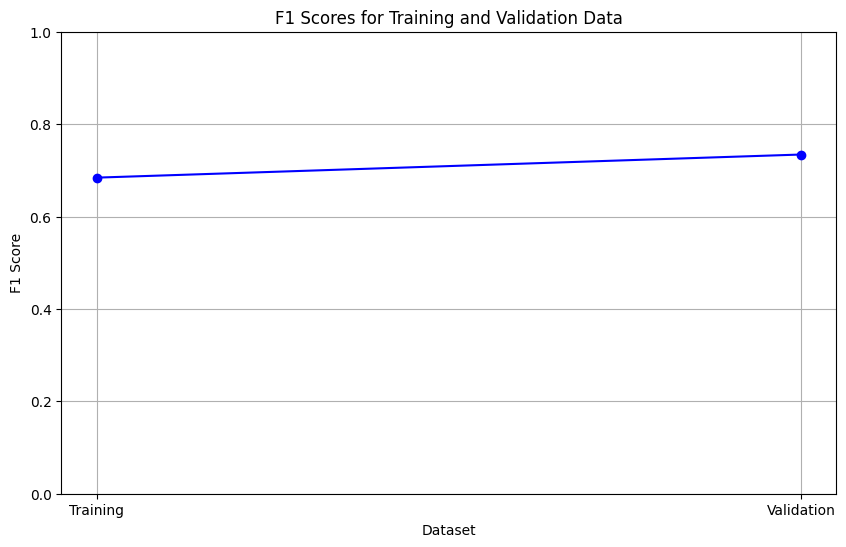

In [ ]:
# Calculate f1 scores
train_f1 = f1_score(y_resampled, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print('SVM f1 score for the best model hyperparameters on training data:', train_f1)
print('SVM f1 score for the best model hyperparameters on validation data:', test_f1)

# Plot the f1 scores
epochs = ['Training', 'Validation']
f1_scores = [train_f1, test_f1]

plt.figure(figsize=(10, 6))
plt.plot(epochs, f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Dataset')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Training and Validation Data')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
#permutation importance
result = permutation_importance(best_svm_model, X_resampled, y_resampled, n_repeats = 10, random_state = 42)
importances = result.importances_mean

# Printing the feature importances
for i, importance in enumerate(importances):
    print(f"Feature {X.columns[i]}: {importance:.4f}")

Feature sentiment_difference: 0.0087
Feature lexiconcount_difference: 0.0025
Feature complex_perc_difference: 0.0783
Feature monosyllabic_difference: 0.0091
Feature word_count_difference: 0.0054


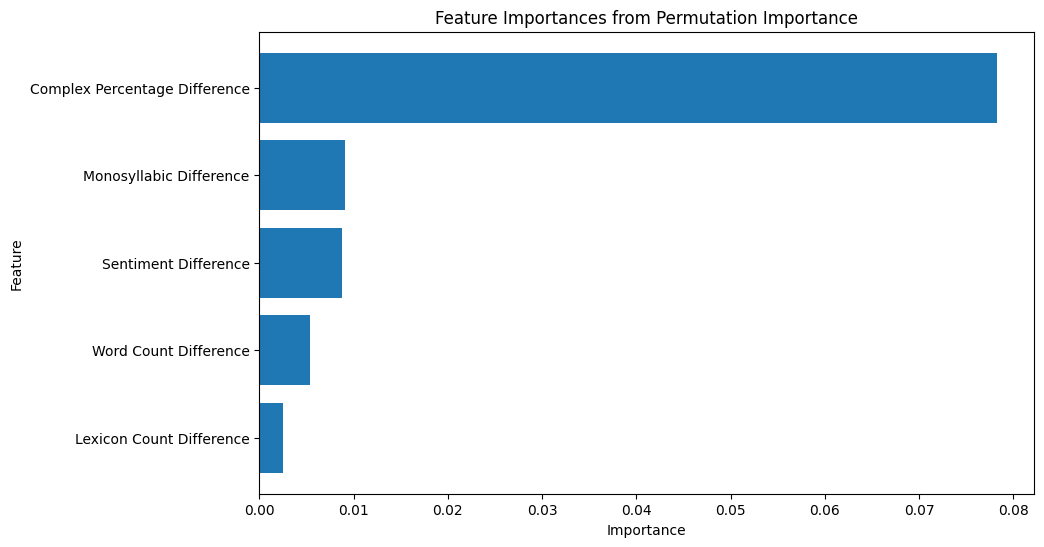

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

feature_name_mapping = {
    'sentiment_difference': 'Sentiment Difference',
    'lexiconcount_difference': 'Lexicon Count Difference',
    'complex_perc_difference': 'Complex Percentage Difference',
    'monosyllabic_difference': 'Monosyllabic Difference',
    'word_count_difference': 'Word Count Difference'
}

new_feature_names = [feature_name_mapping.get(feature, feature) for feature in X.columns]

feature_importances = pd.DataFrame({
    'Feature': new_feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Permutation Importance')
plt.gca().invert_yaxis()
plt.show()
